[UCR Time Series Anomaly Detection Benchmark Datasets](https://arxiv.org/pdf/2009.13807v5.pdf)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from scipy.signal import detrend
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

seed = 0
np.random.seed(seed)

In [3]:
def block_time_series(sequence, block_length):
    X, y, index = [], [], []
    for i in range(len(sequence) - block_length):
        block = sequence[i:i+block_length]
        target = sequence[i+block_length]
        X.append(block)
        y.append(target)
        index.append(np.arange(i, i+block_length))
    return np.array(X), np.array(y), np.array(index)

In [20]:
def compute_empirical_influence_curves(x, y, X, beta, b, seq_len):
  EIC = (seq_len - 1) * np.linalg.inv(X.T @ X) @ (x * (y - x.T @ beta + b))
  return EIC

def compute_loss_grad(x_test, y_test, beta, b):
  loss_grad = x_test * (y_test - x_test.T @ beta + b)
  return loss_grad

def compute_empirical_influences(x, y, x_val, y_val, X, beta, b, seq_len):
  eic = compute_empirical_influence_curves(x, y, X, beta, b, seq_len)
  loss_grad = compute_loss_grad(x_val, y_val, beta, b)
  return loss_grad @ eic

In [23]:
def compute_loo(train_idx, test_idx, X_train, y_train, X_test, y_test):

  n = len(X_train)
  x = X_train[train_idx]
  y = y_train[train_idx]
  mask = np.ones(n).astype(bool)
  mask[train_idx] = 0
  X_masked, y_masked = X_train[mask], y_train[mask]

  lr = LinearRegression().fit(X_masked, y_masked)
  beta = lr.coef_
  b = lr.intercept_

  x_val, y_val = X_test[test_idx], y_test[test_idx]

  loo = compute_empirical_influences(x, y, x_val, y_val, X_masked, beta, b, n)
  return loo

Dataset 1

In [11]:
data_dir = "/content/drive/MyDrive/time_series_influences/ucr_time_series_anomaly_datasets/data/"
file_name = "037_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG1_5000_17210_17260.txt"
ts = pd.read_csv(Path(data_dir) / file_name, delimiter='\t', header=None).to_numpy()
ts = ts[17000:17800].squeeze()

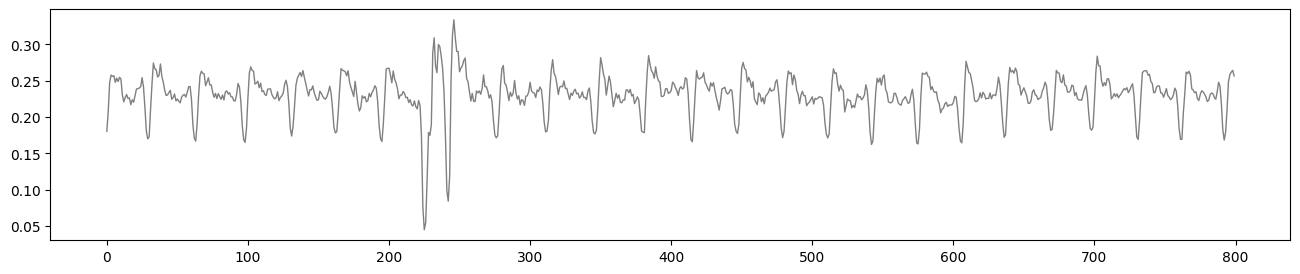

In [12]:
plt.figure(figsize=(16,3))
plt.plot(ts, c="gray", linewidth=1)
plt.show()

In [13]:
seq_len = len(ts)
train_len = int(0.9 * seq_len)
test_len = int(0.1 * seq_len)
ts_train, ts_test = ts[:700], ts[700:]

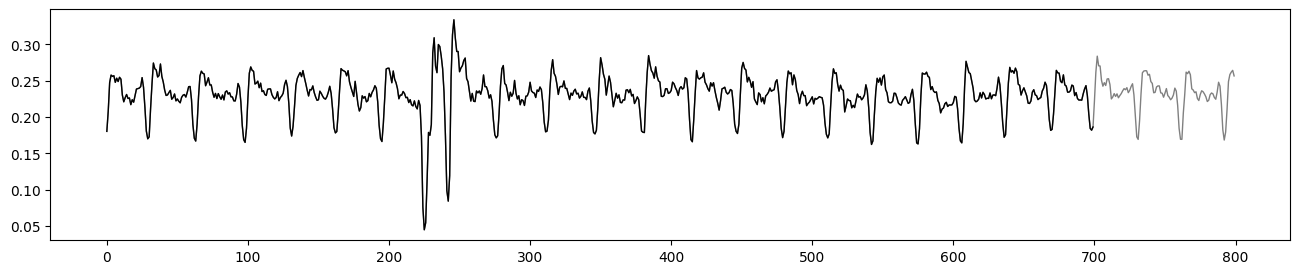

In [14]:
plt.figure(figsize=(16,3))
plt.plot(ts, c="gray", linewidth=1)
plt.plot(ts_train, c="k", linewidth=1)
plt.show()

In [15]:
block_length = 50
X_train, y_train, block_index = block_time_series(ts_train, block_length)
X_test, y_test, _ = block_time_series(ts_test, block_length)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(650, 50) (650,)
(50, 50) (50,)


In [16]:
train_block_index = []
for i in range(len(X_train)):
  train_index = []
  for j in range(len(X_train)):
    if i in block_index[j]:
      train_index.append(j)
  train_block_index.append(train_index)

In [17]:
lr = LinearRegression().fit(X_train, y_train)
y_hat = lr.predict(X_train)
y_pred = lr.predict(X_test)

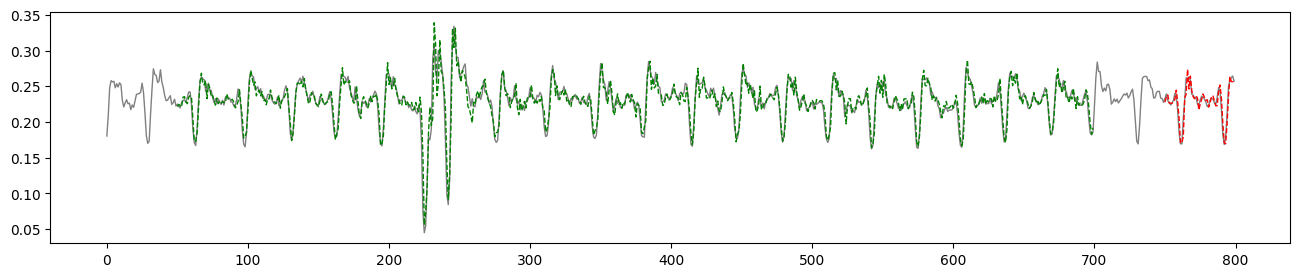

In [18]:
plt.figure(figsize=(16,3))
train_pred = np.ones_like(ts) * np.nan
test_pred = train_pred.copy()
train_pred[block_length:block_length + len(y_hat)] = y_hat
test_pred[-len(y_pred):] = y_pred
plt.plot(ts, c="gray", linewidth=1);
plt.plot(train_pred, c="g", linewidth=1, linestyle="--")
plt.plot(test_pred, c="r", linewidth=1, linestyle="--")
plt.show()

In [27]:
train_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  test_loos = []
  for j in np.arange(len(X_test)):
    test_loos.append(compute_loo(i, j, X_train, y_train, X_test, y_test))
  train_loos.append(np.mean(test_loos))
train_loos = np.array(train_loos)

Compute LOO: 100%|██████████| 650/650 [02:58<00:00,  3.64it/s]


In [28]:
mean_loos = []
for i in range(len(train_block_index)):
  mean_loos.append((train_loos[train_block_index[i]]).mean())
mean_loos = np.array(mean_loos)

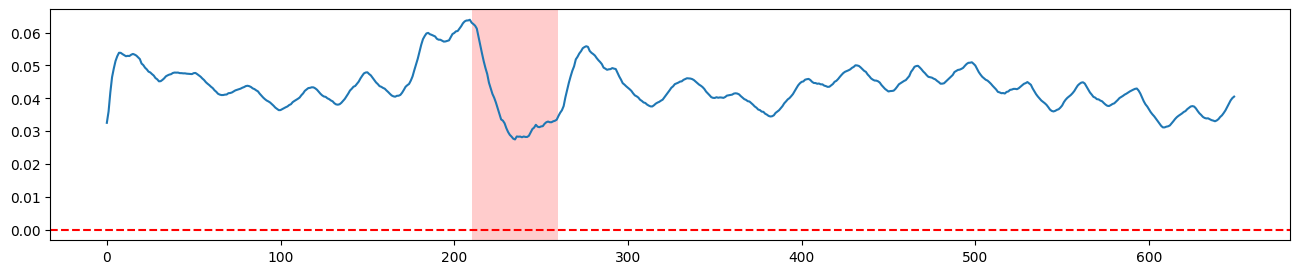

In [29]:
plt.figure(figsize=(16,3))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = mean_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(210, 260, facecolor='red', alpha=.2);

Dataset 2

In [63]:
data_dir = "/content/drive/MyDrive/time_series_influences/ucr_time_series_anomaly_datasets/data/"
file_name = "042_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG6_7000_12190_12420.txt"

ts = pd.read_csv(Path(data_dir) / file_name, delimiter='\t', header=None).to_numpy()
ts = ts[11500:13000].squeeze()

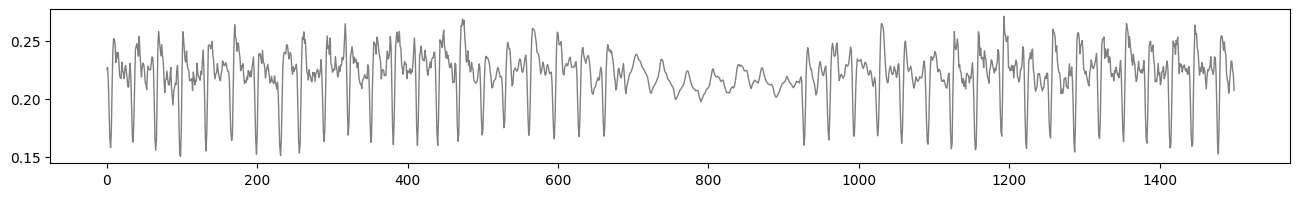

In [64]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.show()

In [67]:
seq_len = len(ts)
train_len = int(0.8 * seq_len)
test_len = int(0.2 * seq_len)
ts_train, ts_test = ts[:train_len], ts[train_len:]

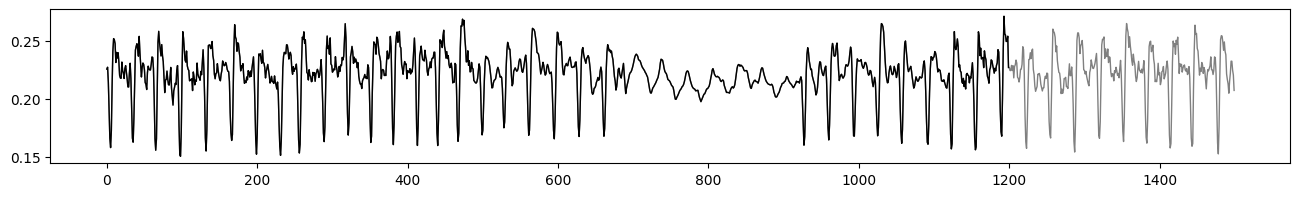

In [68]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.plot(ts_train, c="k", linewidth=1)
plt.show()

In [69]:
block_length = 50
X_train, y_train, block_index = block_time_series(ts_train, block_length)
X_test, y_test, _ = block_time_series(ts_test, block_length)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1150, 50) (1150,)
(250, 50) (250,)


In [71]:
train_block_index = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Find block index"):
  train_index = []
  for j in range(len(X_train)):
    if i in block_index[j]:
      train_index.append(j)
  train_block_index.append(train_index)

Find block index: 100%|██████████| 1150/1150 [00:04<00:00, 234.46it/s]


In [72]:
lr = LinearRegression().fit(X_train, y_train)
y_hat = lr.predict(X_train)
y_pred = lr.predict(X_test)

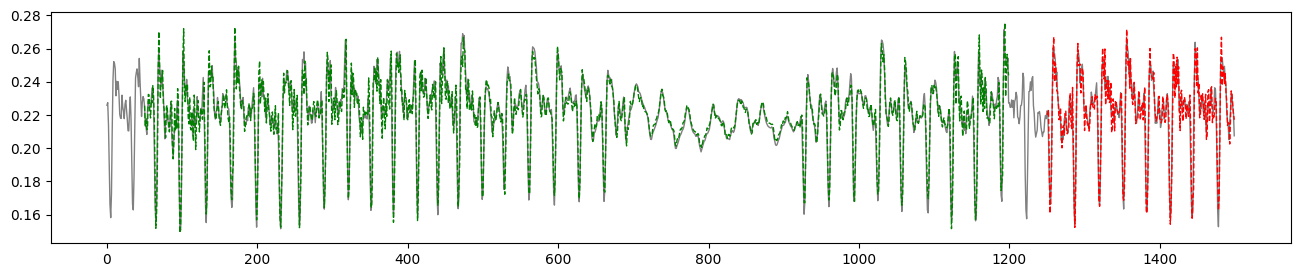

In [73]:
plt.figure(figsize=(16,3))
train_pred = np.ones_like(ts) * np.nan
test_pred = train_pred.copy()
train_pred[block_length:block_length + len(y_hat)] = y_hat
test_pred[-len(y_pred):] = y_pred
plt.plot(ts, c="gray", linewidth=1);
plt.plot(train_pred, c="g", linewidth=1, linestyle="--")
plt.plot(test_pred, c="r", linewidth=1, linestyle="--")
plt.show()

In [78]:
train_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  test_loos = []
  for j in np.arange(len(X_test)):
    test_loos.append(compute_loo(i, j, X_train, y_train, X_test, y_test))
  train_loos.append(np.mean(test_loos))
train_loos = np.array(train_loos)

Compute LOO: 100%|██████████| 1150/1150 [32:15<00:00,  1.68s/it]


In [79]:
mean_loos = []
for i in range(len(train_block_index)):
  mean_loos.append((train_loos[train_block_index[i]]).mean())
mean_loos = np.array(mean_loos)

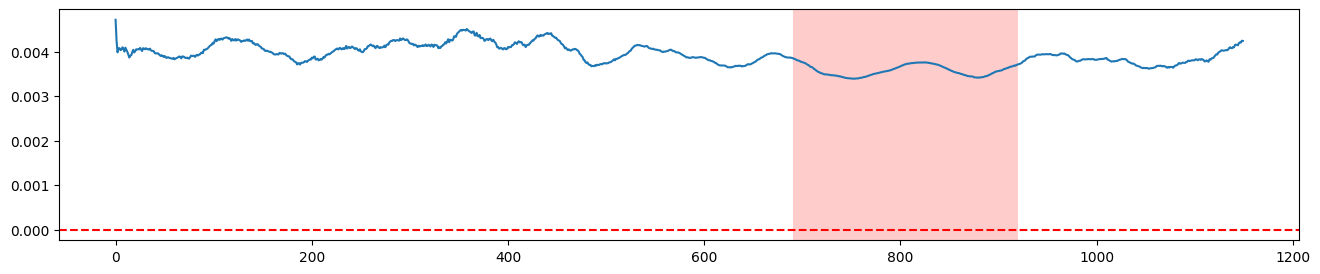

In [80]:
plt.figure(figsize=(16,3))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = mean_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(690, 920, facecolor='red', alpha=.2);

Dataset 3

In [50]:
data_dir = "/content/drive/MyDrive/time_series_influences/ucr_time_series_anomaly_datasets/data/"
file_name = "003_UCR_Anomaly_DISTORTED3sddb40_35000_46600_46900.txt"

ts = pd.read_csv(Path(data_dir) / file_name, delimiter='\t', header=None).to_numpy()
ts = ts[46000:47500].squeeze()

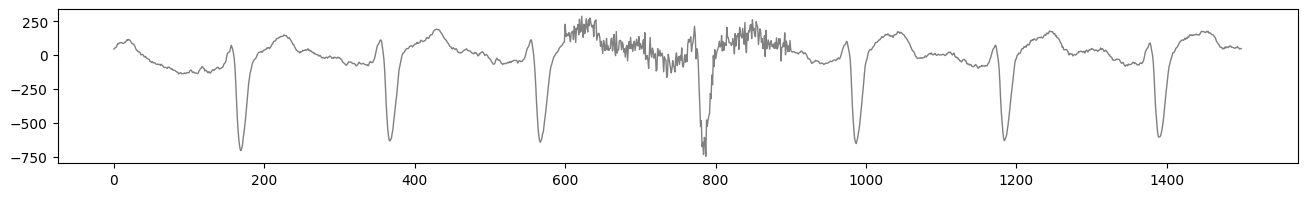

In [51]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.show()

In [52]:
seq_len = len(ts)
train_len = int(0.8 * seq_len)
test_len = int(0.2 * seq_len)
ts_train, ts_test = ts[:train_len], ts[train_len:]

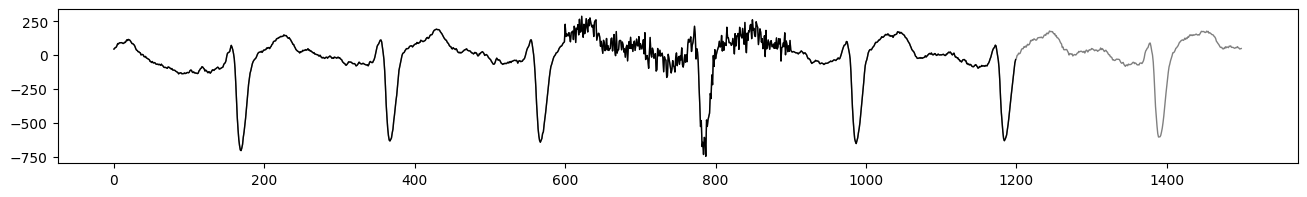

In [53]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.plot(ts_train, c="k", linewidth=1)
plt.show()

In [54]:
block_length = 50
X_train, y_train, block_index = block_time_series(ts_train, block_length)
X_test, y_test, _ = block_time_series(ts_test, block_length)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1150, 50) (1150,)
(250, 50) (250,)


In [56]:
train_block_index = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Find block index"):
  train_index = []
  for j in range(len(X_train)):
    if i in block_index[j]:
      train_index.append(j)
  train_block_index.append(train_index)

Find block index: 100%|██████████| 1150/1150 [00:04<00:00, 269.68it/s]


In [57]:
lr = LinearRegression().fit(X_train, y_train)
y_hat = lr.predict(X_train)
y_pred = lr.predict(X_test)

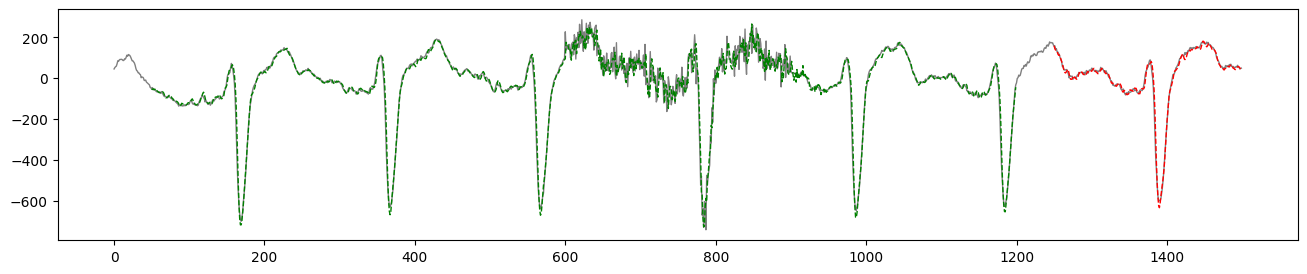

In [58]:
plt.figure(figsize=(16,3))
train_pred = np.ones_like(ts) * np.nan
test_pred = train_pred.copy()
train_pred[block_length:block_length + len(y_hat)] = y_hat
test_pred[-len(y_pred):] = y_pred
plt.plot(ts, c="gray", linewidth=1);
plt.plot(train_pred, c="g", linewidth=1, linestyle="--")
plt.plot(test_pred, c="r", linewidth=1, linestyle="--")
plt.show()

In [59]:
train_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  test_loos = []
  for j in np.arange(len(X_test)):
    test_loos.append(compute_loo(i, j, X_train, y_train, X_test, y_test))
  train_loos.append(np.mean(test_loos))
train_loos = np.array(train_loos)

Compute LOO: 100%|██████████| 1150/1150 [32:16<00:00,  1.68s/it]


In [60]:
mean_loos = []
for i in range(len(train_block_index)):
  mean_loos.append((train_loos[train_block_index[i]]).mean())
mean_loos = np.array(mean_loos)

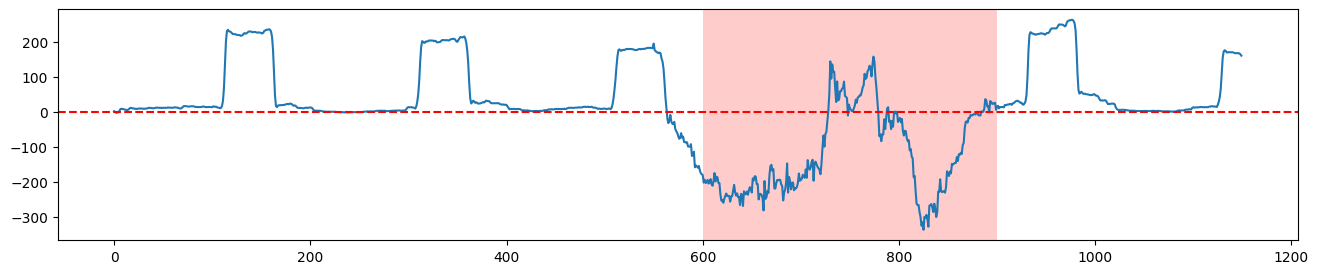

In [61]:
plt.figure(figsize=(16,3))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = mean_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(600, 900, facecolor='red', alpha=.2);

Dataset 4

In [89]:
data_dir = "/content/drive/MyDrive/time_series_influences/ucr_time_series_anomaly_datasets/data/"
file_name = "062_UCR_Anomaly_DISTORTEDgaitHunt1_18500_33070_33180.txt"

ts = pd.read_csv(Path(data_dir) / file_name, delimiter='\t', header=None).to_numpy()
ts = ts[33000:34000].squeeze()

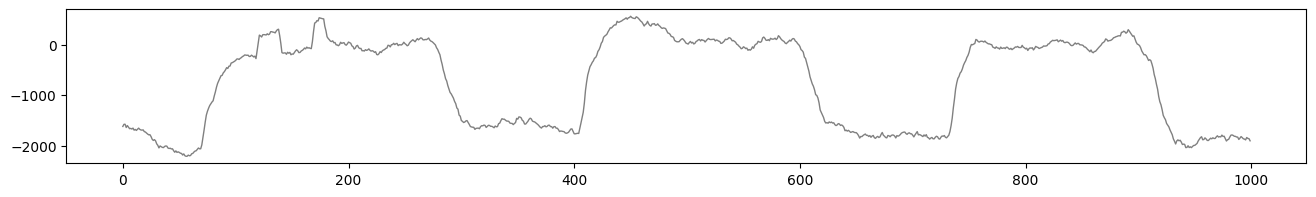

In [90]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.show()

In [95]:
seq_len = len(ts)
train_len = int(0.7 * seq_len)
test_len = int(0.3 * seq_len)
ts_train, ts_test = ts[:train_len], ts[train_len:]

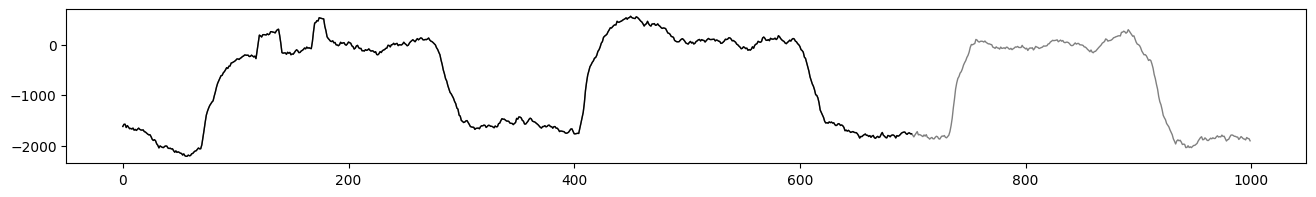

In [96]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.plot(ts_train, c="k", linewidth=1)
plt.show()

In [102]:
block_length = 25
X_train, y_train, block_index = block_time_series(ts_train, block_length)
X_test, y_test, _ = block_time_series(ts_test, block_length)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(675, 25) (675,)
(275, 25) (275,)


In [104]:
train_block_index = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Find block index"):
  train_index = []
  for j in range(len(X_train)):
    if i in block_index[j]:
      train_index.append(j)
  train_block_index.append(train_index)

Find block index: 100%|██████████| 675/675 [00:06<00:00, 98.16it/s] 


In [105]:
lr = LinearRegression().fit(X_train, y_train)
y_hat = lr.predict(X_train)
y_pred = lr.predict(X_test)

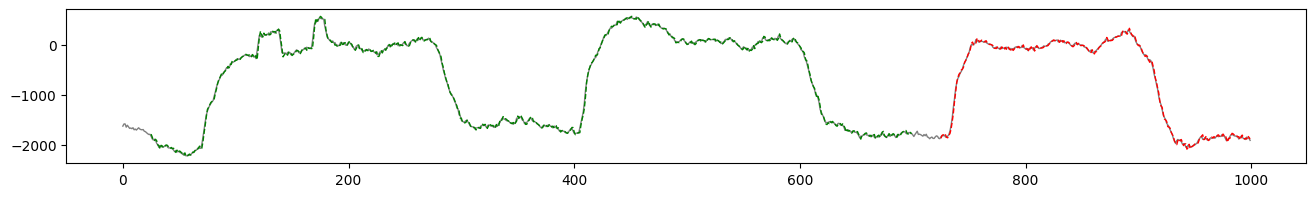

In [106]:
plt.figure(figsize=(16,2))
train_pred = np.ones_like(ts) * np.nan
test_pred = train_pred.copy()
train_pred[block_length:block_length + len(y_hat)] = y_hat
test_pred[-len(y_pred):] = y_pred
plt.plot(ts, c="gray", linewidth=1);
plt.plot(train_pred, c="g", linewidth=1, linestyle="--")
plt.plot(test_pred, c="r", linewidth=1, linestyle="--")
plt.show()

In [107]:
train_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  test_loos = []
  for j in np.arange(len(X_test)):
    test_loos.append(compute_loo(i, j, X_train, y_train, X_test, y_test))
  train_loos.append(np.mean(test_loos))
train_loos = np.array(train_loos)

Compute LOO: 100%|██████████| 675/675 [21:59<00:00,  1.96s/it]


In [111]:
mean_loos = []
for i in range(len(train_block_index)):
  mean_loos.append((train_loos[train_block_index[i]]).mean())
mean_loos = np.array(mean_loos)

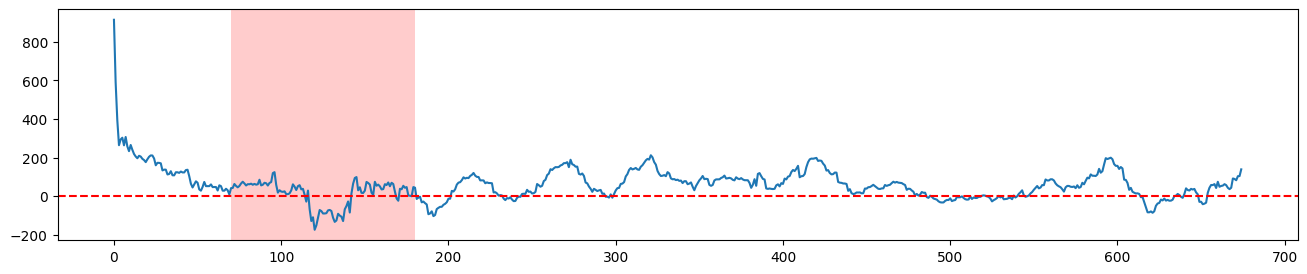

In [112]:
plt.figure(figsize=(16,3))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = mean_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(70, 180, facecolor='red', alpha=.2);